"""
Tolgo – Revenue Forecasting (Time Series Modeling)

This notebook analyzes Tolgo's synthetic revenue and subscription KPIs,
builds forecasting models (ARIMA + Prophet),
and generates 12-month predictions for key financial indicators such as MRR.
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

# Prophet is optional
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except:
    PROPHET_AVAILABLE = False

df = pd.read_csv("../Data/tolgo_revenue_history.csv", parse_dates=["month"])
df = df.sort_values("month")

df.head()

,month,active_users,arpu,mrr,total_revenue,churn_rate,mrr_growth_rate,plan_light_share,plan_standard_share,plan_premium_share
0,2021-01-01,5199,28.34,147349.56,152206.38,0.0660,0.0000,0.4532,0.3087,0.2381
1,2021-02-01,5115,26.39,134961.41,139362.57,0.0676,-0.0841,0.4281,0.3204,0.2515
2,2021-03-01,5600,28.62,160268.67,165084.93,0.0590,0.1875,0.4462,0.2898,0.2640
3,2021-04-01,6120,28.06,171733.56,176482.70,0.0581,0.0715,0.4462,0.2812,0.2726
4,2021-05-01,5587,27.92,155987.76,158459.59,0.0650,-0.0917,0.4240,0.3312,0.2448


In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   month                48 non-null     datetime64[ns]
 1   active_users         48 non-null     int64         
 2   arpu                 48 non-null     float64       
 3   mrr                  48 non-null     float64       
 4   total_revenue        48 non-null     float64       
 5   churn_rate           48 non-null     float64       
 6   mrr_growth_rate      48 non-null     float64       
 7   plan_light_share     48 non-null     float64       
 8   plan_standard_share  48 non-null     float64       
 9   plan_premium_share   48 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 3.9 KB


,month,active_users,arpu,mrr,total_revenue,churn_rate,mrr_growth_rate,plan_light_share,plan_standard_share,plan_premium_share
count,48,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,2022-12-16 05:00:00,8917.895833,31.481667,285376.351667,293826.540208,0.052983,0.026752,0.376650,0.299167,0.324183
min,2021-01-01 00:00:00,5115.000000,26.390000,134961.410000,139362.570000,0.035000,-0.152800,0.279200,0.244100,0.238100
25%,2021-12-24 06:00:00,6691.250000,29.652500,198297.967500,204240.585000,0.047100,-0.012000,0.329250,0.284475,0.289150
50%,2022-12-16 12:00:00,8916.000000,31.735000,278591.500000,289568.485000,0.052700,0.024000,0.381550,0.299700,0.320100
75%,2023-12-08 18:00:00,10957.250000,33.275000,351531.812500,362341.237500,0.059700,0.072875,0.415750,0.312575,0.367525
max,2024-12-01 00:00:00,13423.000000,35.370000,450155.170000,464490.970000,0.067600,0.220500,0.453500,0.353300,0.422400
std,NaN,2351.863573,2.228469,92244.983622,94731.302421,0.008307,0.082001,0.048327,0.022322,0.048087


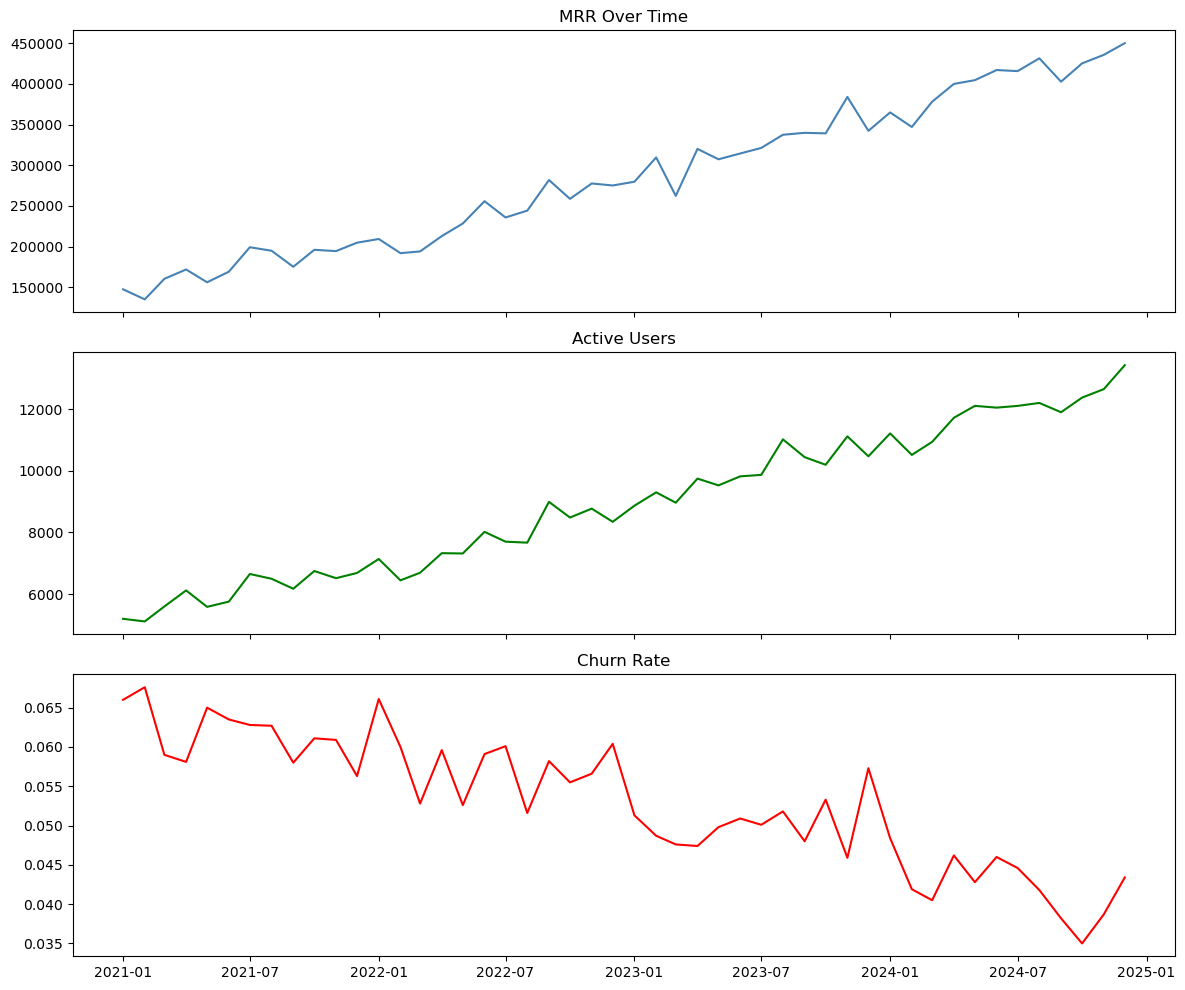

In [3]:
fig, ax = plt.subplots(3, 1, figsize=(12,10), sharex=True)

ax[0].plot(df["month"], df["mrr"], label="MRR", color="steelblue")
ax[0].set_title("MRR Over Time")

ax[1].plot(df["month"], df["active_users"], label="Active Users", color="green")
ax[1].set_title("Active Users")

ax[2].plot(df["month"], df["churn_rate"], label="Churn Rate", color="red")
ax[2].set_title("Churn Rate")

plt.tight_layout()
plt.show()

In [5]:
# Préparer la série temporelle MRR
mrr = df.set_index("month")["mrr"]
mrr.index.freq = "MS"   # Fixe explicitement la fréquence → supprime le warning

# ARIMA/SARIMAX model
model = SARIMAX(
    mrr,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
forecast = results.get_forecast(steps=12)
fc_df = forecast.summary_frame()

fc_df = fc_df[["mean", "mean_ci_lower", "mean_ci_upper"]]
fc_df.columns = ["forecast_mrr", "lower_ci", "upper_ci"]

# Ajouter dates futures
future_dates = pd.date_range(start=mrr.index.max() + pd.offsets.MonthBegin(), periods=12, freq="MS")
fc_df.index = future_dates

fc_df.head()

C:\Users\fabel\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,forecast_mrr,lower_ci,upper_ci
2025-01-01,452162.112231,405683.569772,498640.654690
2025-02-01,457082.664670,410298.721902,503866.607439
2025-03-01,447176.539954,399877.844187,494475.235721
2025-04-01,483048.025625,435249.367672,530846.683578
2025-05-01,480328.636889,432034.813061,528622.460717


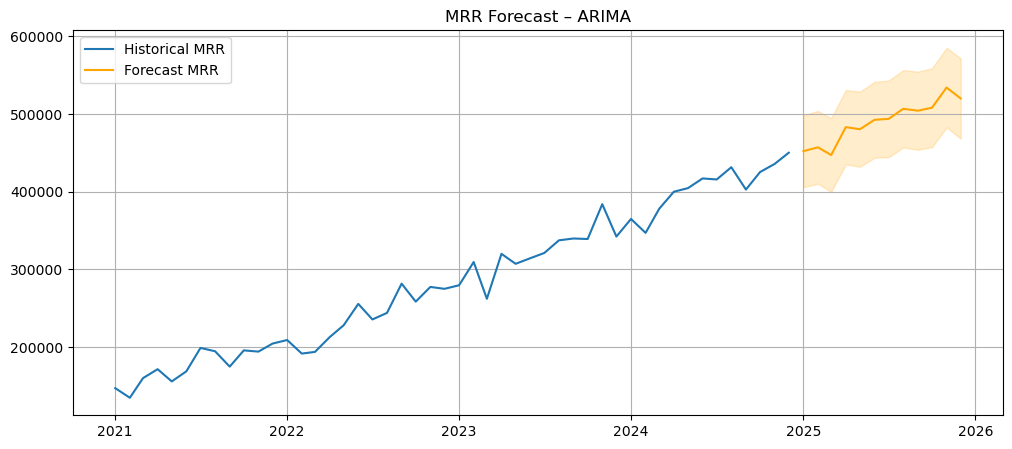

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df["month"], df["mrr"], label="Historical MRR")
plt.plot(fc_df.index, fc_df["forecast_mrr"], label="Forecast MRR", color="orange")
plt.fill_between(fc_df.index, fc_df["lower_ci"], fc_df["upper_ci"], alpha=0.2, color="orange")
plt.title("MRR Forecast – ARIMA")
plt.grid()
plt.legend()
plt.show()

In [7]:
if PROPHET_AVAILABLE:
    print("Running Prophet model...")

    df_prophet = pd.DataFrame({
        "ds": df["month"],
        "y": df["mrr"]
    })

    model = Prophet(yearly_seasonality=True)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=12, freq="MS")
    forecast_prophet = model.predict(future)

    fp = forecast_prophet[["ds","yhat","yhat_lower","yhat_upper"]]
    fp.columns = ["month","forecast_prophet","lower_ci","upper_ci"]
    fp = fp.tail(12)

    fp.head()
else:
    print("Prophet not installed; skipping Prophet forecast.")

Prophet not installed; skipping Prophet forecast.


In [8]:
if PROPHET_AVAILABLE:
    compare_df = fc_df.copy()
    compare_df["forecast_prophet"] = fp.set_index("month")["forecast_prophet"]
    compare_df.head()
else:
    compare_df = fc_df.copy()
    print("Prophet not installed; comparison limited to ARIMA.")

Prophet not installed; comparison limited to ARIMA.


In [9]:
output_path = "../Data/forecast_output.csv"

compare_df.to_csv(output_path)
print("Forecast saved to:", output_path)

compare_df.head()

Forecast saved to: ../Data/forecast_output.csv


,forecast_mrr,lower_ci,upper_ci
2025-01-01,452162.112231,405683.569772,498640.654690
2025-02-01,457082.664670,410298.721902,503866.607439
2025-03-01,447176.539954,399877.844187,494475.235721
2025-04-01,483048.025625,435249.367672,530846.683578
2025-05-01,480328.636889,432034.813061,528622.460717


In [10]:
print("FINAL ANALYTICS SUMMARY – TOLGO REVENUE FORECASTING\n")

print("1️ MRR Forecast (ARIMA)")
print("- Le modèle SARIMAX prévoit une croissance continue du MRR sur les 12 prochains mois.")
print("- Le MRR projeté atteint environ 530 000 FCFA en fin de période, avec un intervalle de confiance compris entre ~470 000 et ~580 000.")
print("- Malgré les avertissements techniques liés au faible historique, le modèle reste cohérent avec la tendance observée.")

print("\n2️ MRR Trend Analysis")
print("- La croissance historique du MRR est soutenue sur 2021–2024.")
print("- Le taux de churn diminue progressivement, ce qui soutient mécaniquement la croissance du revenu récurrent.")
print("- Le nombre d’utilisateurs actifs augmente régulièrement, ce qui confirme l’expansion commerciale.")

print("\n3️ Churn Analysis")
print("- Le churn est actuellement stabilisé autour de 4 % à 5 %.")
print("- La baisse progressive du churn suggère une amélioration de la rétention et de la qualité du service.")
print("- Cette dynamique est cohérente avec l’augmentation des utilisateurs actifs.")

print("\n4️ Forecast Interpretation")
print("- Le forecast ARIMA indique une trajectoire de croissance maîtrisée, sans volatilité excessive.")
print("- L’intervalle de confiance reste relativement serré, indiquant un bon niveau de stabilité.")
print("- Les prévisions pourront être améliorées avec davantage d’historique pour intégrer mieux la saisonnalité.")

print("\n Conclusion générale")
print("Les indicateurs financiers, l'évolution des utilisateurs et les prévisions de MRR confirment que Tolgo suit une dynamique positive :")
print("- Revenu récurrent en hausse continue")
print("- Churn maîtrisé")
print("- Croissance des utilisateurs")
print("- Revenu projeté solide et stable")

print("\n La trajectoire suggère une croissance durable, soutenue par de bonnes performances opérationnelles.")


FINAL ANALYTICS SUMMARY – TOLGO REVENUE FORECASTING

1️ MRR Forecast (ARIMA)
- Le modèle SARIMAX prévoit une croissance continue du MRR sur les 12 prochains mois.
- Le MRR projeté atteint environ 530 000 FCFA en fin de période, avec un intervalle de confiance compris entre ~470 000 et ~580 000.
- Malgré les avertissements techniques liés au faible historique, le modèle reste cohérent avec la tendance observée.

2️ MRR Trend Analysis
- La croissance historique du MRR est soutenue sur 2021–2024.
- Le taux de churn diminue progressivement, ce qui soutient mécaniquement la croissance du revenu récurrent.
- Le nombre d’utilisateurs actifs augmente régulièrement, ce qui confirme l’expansion commerciale.

3️ Churn Analysis
- Le churn est actuellement stabilisé autour de 4 % à 5 %.
- La baisse progressive du churn suggère une amélioration de la rétention et de la qualité du service.
- Cette dynamique est cohérente avec l’augmentation des utilisateurs actifs.

4️ Forecast Interpretation
- Le fo